# IRI forecast as a trigger for drought in Burkina Faso
This notebook explores the option of using IRI's seasonal forecast as the indicator for a drought-related trigger in Burkina Faso. 
From the country team the proposed trigger is:
- Trigger #1 in March covering June-July-August. Threshold desired: 40%.
- Trigger #2 in July covering Aug-Sep-Oct. Threshold desired: 50%. 
- Targeted Admin1s: Boucle de Mounhoun, Centre Nord, Sahel, Nord.

This notebook explores if and when these triggers would be reached. Moreover, an exploration is done on how the raster data can be combined to come to one value for all 4 admin1s.

<!-- - Trigger #1 in March covering Apr-May-June. Threshold desired: 40%.
- Trigger #2 in July covering Aug-Sep-Oct. Threshold desired: 50%.  -->

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from rasterstats import zonal_stats
from IPython.display import Markdown as md
from myst_nb import glue

from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

from src.indicators.drought.iri_rainfallforecast import get_iri_data
from src.utils_general.raster_manipulation import invert_latlon,change_longitude_range,fix_calendar

In [57]:
import cftime

## Inspect forecasts

In [3]:
adm_sel=["Boucle du Mouhoun","Nord","Centre-Nord","Sahel"]
threshold_mar=40
threshold_jul=50

In [86]:
leadtime_mar=3
leadtime_jul=1
glue("leadtime_mar", leadtime_mar)
glue("leadtime_jul", leadtime_jul)

3

1

In [5]:
country="bfa"
config=Config()
parameters = config.parameters(country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.RAW_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration",country)
glb_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration","glb")
iri_exploration_dir=os.path.join(country_data_exploration_dir,"iri")
stats_reg_path=os.path.join(country_data_exploration_dir,f"{country}_iri_seasonal_forecast_stats_{''.join(adm_sel)}.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [6]:
iri_ds, iri_transform = get_iri_data(config, download=False)

these are the variables of the forecast data, where C indicates the tercile (below-average, normal, or above-average).  
F indicates the publication month, and L the leadtime

In [7]:
iri_ds

<xarray.Dataset>
Dimensions:      (C: 3, F: 51, L: 4, lat: 181, lon: 360)
Coordinates:
  * lat          (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * L            (L) float32 1.0 2.0 3.0 4.0
  * lon          (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-05-16 00:00:00
    spatial_ref  int64 ...
Dimensions without coordinates: C
Data variables:
    prob         (F, L, C, lat, lon) float64 ...
Attributes:
    grid_mapping:  spatial_ref

In [9]:
gdf_adm1=gpd.read_file(adm1_bound_path)
iri_clip=iri_ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.clip(gdf_adm1.geometry.apply(mapping), iri_ds.rio.crs, all_touched=True)

In [10]:
gdf_reg=gdf_adm1[gdf_adm1.ADM1_FR.isin(adm_sel)]

Below the raw forecast data of below-average rainfall with {glue:text}`leadtime_mar` month leadtime, published in March is shown. The red areas are the 4 admin1's we are focussing on

The negative values indicate below average rainfall, and the positive values above average.

This is similair to [the figure on the IRI Maproom](https://iridl.ldeo.columbia.edu/maproom/Global/Forecasts/NMME_Seasonal_Forecasts/Precipitation_ELR.html), except that the bins are defined slightly differently

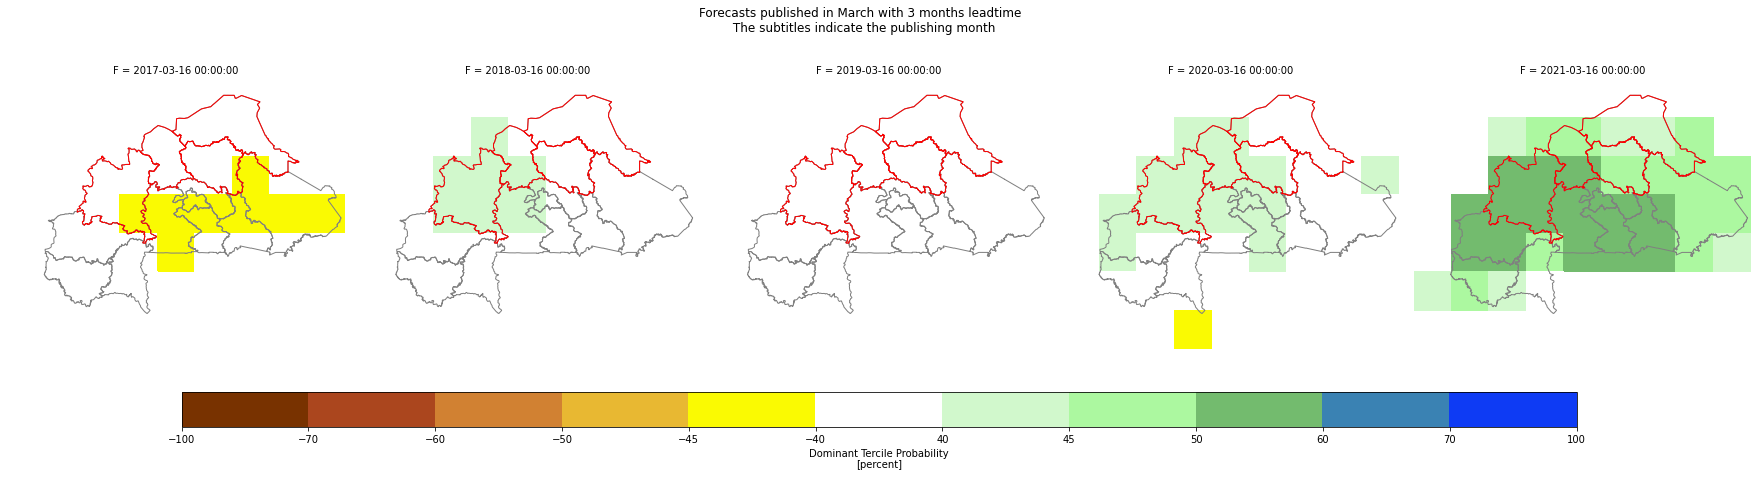

In [158]:
dom_ds=xr.open_dataset(os.path.join(glb_data_exploration_dir,"iri","iri_seasfor_tercile_dominant.nc"), decode_times=False, drop_variables='C')
dom_ds=dom_ds.rename({"X": "lon", "Y": "lat"})
#often IRI latitude is flipped so check for that and invert if needed
dom_ds = invert_latlon(dom_ds)
dom_ds = change_longitude_range(dom_ds)
dom_ds = fix_calendar(dom_ds, timevar='F')
dom_ds = xr.decode_cf(dom_ds)
dom_clip=dom_ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.clip(gdf_adm1.geometry.apply(mapping), dom_ds.rio.crs, all_touched=True)
levels=[-100,-70,-60,-50,-45,-40,40,45,50,60,70,100]
#iri website bins
# levels=[-100,-67.5,-57.5,-47.5,-42.5,-37.5,37.5,42.5,47.5,57.5,67.5,100]
colors=['#783200','#ab461e','#d18132','#e8b832','#fafa02','#ffffff','#d1f8cc','#acf8a0','#73bb6e','#3a82b3','#0e3bf4']
g=dom_clip.where(dom_clip.F.dt.month.isin([3]), drop=True).sel(L=3).dominant.plot(
    col="F",
    col_wrap=5,
    levels=levels,
    colors=colors,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        'ticks': levels,
    },
    figsize=(25,7)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="grey")
    gdf_reg.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")
    
g.fig.suptitle("Forecasts published in March with 3 months leadtime \n The subtitles indicate the publishing month")
# g.fig.tight_layout()
plt.savefig(os.path.join(country_data_exploration_dir,"plots","iri","bfa_irifor_mar_l3.png"))

The same figure, but for the forecasts published in July with a {glue:text}`leadtime_jul` month leadtime are shown below

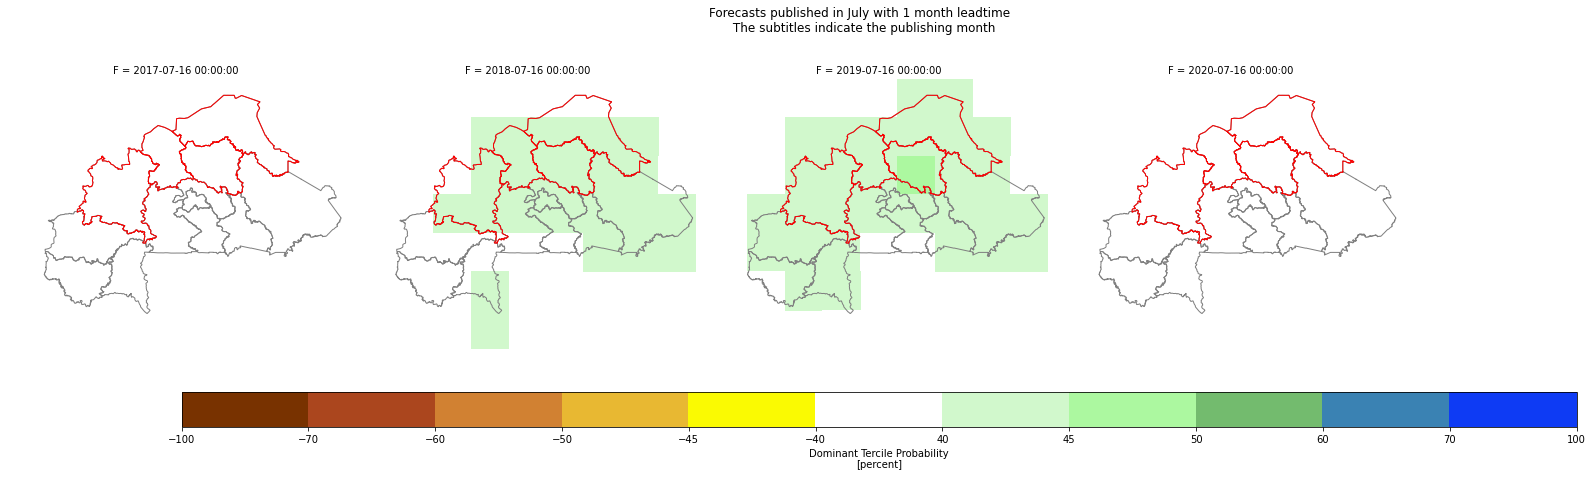

In [159]:
dom_ds=xr.open_dataset(os.path.join(glb_data_exploration_dir,"iri","iri_seasfor_tercile_dominant.nc"), decode_times=False, drop_variables='C')
dom_ds=dom_ds.rename({"X": "lon", "Y": "lat"})
#often IRI latitude is flipped so check for that and invert if needed
dom_ds = invert_latlon(dom_ds)
dom_ds = change_longitude_range(dom_ds)
dom_ds = fix_calendar(dom_ds, timevar='F')
dom_ds = xr.decode_cf(dom_ds)
dom_clip=dom_ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.clip(gdf_adm1.geometry.apply(mapping), dom_ds.rio.crs, all_touched=True)
levels=[-100,-70,-60,-50,-45,-40,40,45,50,60,70,100]
#iri website bins
# levels=[-100,-67.5,-57.5,-47.5,-42.5,-37.5,37.5,42.5,47.5,57.5,67.5,100]
colors=['#783200','#ab461e','#d18132','#e8b832','#fafa02','#ffffff','#d1f8cc','#acf8a0','#73bb6e','#3a82b3','#0e3bf4']
g=dom_clip.where(dom_clip.F.dt.month.isin([7]), drop=True).sel(L=1).dominant.plot(
    col="F",
    col_wrap=5,
    levels=levels,
    colors=colors,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        'ticks': levels,
    },
    figsize=(25,7)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="grey")
    gdf_reg.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")
    
g.fig.suptitle("Forecasts published in July with 1 month leadtime \n The subtitles indicate the publishing month")
# g.fig.tight_layout()
plt.savefig(os.path.join(country_data_exploration_dir,"plots","iri","bfa_irifor_jul_l1.png"))

Some forecasts where we see a combination of below and above average are shown below. This is to guide the discussion on for which forecasts we would have wanted to trigger and for which we wouldn't

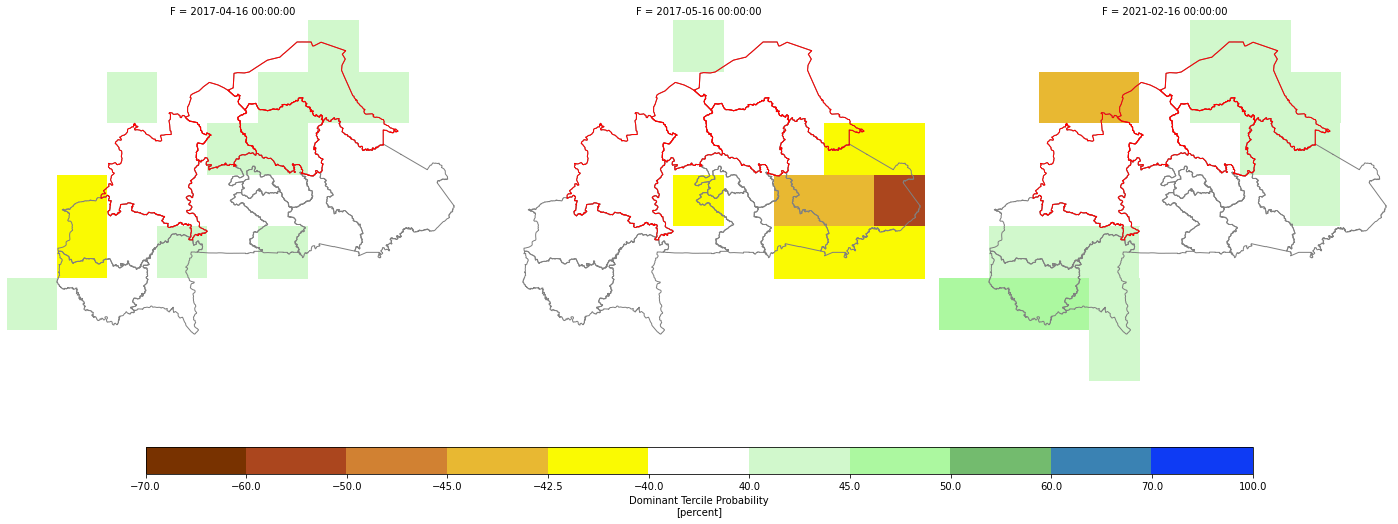

In [81]:
g=dom_clip.where(dom_clip.F.isin([cftime.Datetime360Day(2021, 2, 16, 0, 0, 0, 0),cftime.Datetime360Day(2017, 5, 16, 0, 0, 0, 0),cftime.Datetime360Day(2017, 4, 16, 0, 0, 0, 0)]),drop=True).sel(L=3).dominant.plot(
    col="F",
    col_wrap=3,
    levels=levels,
    colors=colors,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        'ticks': levels,
    },
    figsize=(20,10)
)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="grey")
    gdf_reg.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [17]:
def interpolate_ds(ds,transform,upscale_factor):
    # Interpolated data
    new_lon = np.linspace(ds.lon[0], ds.lon[-1], ds.dims["lon"] * upscale_factor)
    new_lat = np.linspace(ds.lat[0], ds.lat[-1], ds.dims["lat"] * upscale_factor)

    #choose nearest as interpolation method to assure no new values are introduced but instead old values are divided into smaller raster cells
    dsi = ds.interp(lat=new_lat, lon=new_lon,method="nearest")
#     transform_interp=transform*transform.scale(len(ds.lon)/len(dsi.lon),len(ds.lat)/len(dsi.lat))
    
    return dsi#, transform_interp

In [18]:
iri_clip_interp=interpolate_ds(iri_clip,iri_clip.rio.transform(),8)

In [19]:
iri_clip_interp

<xarray.Dataset>
Dimensions:      (C: 3, F: 51, L: 4, lat: 56, lon: 72)
Coordinates:
  * L            (L) float32 1.0 2.0 3.0 4.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-05-16 00:00:00
    spatial_ref  int64 0
  * lat          (lat) float64 15.0 14.89 14.78 14.67 ... 9.327 9.218 9.109 9.0
  * lon          (lon) float64 -6.0 -5.887 -5.775 -5.662 ... 1.775 1.887 2.0
Dimensions without coordinates: C
Data variables:
    prob         (F, L, C, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [20]:
iri_clip_interp.rio.transform(recalc=True)

Affine(0.11267605633802817, 0.0, -6.056338028169014,
       0.0, -0.10909090909090909, 15.054545454545455)

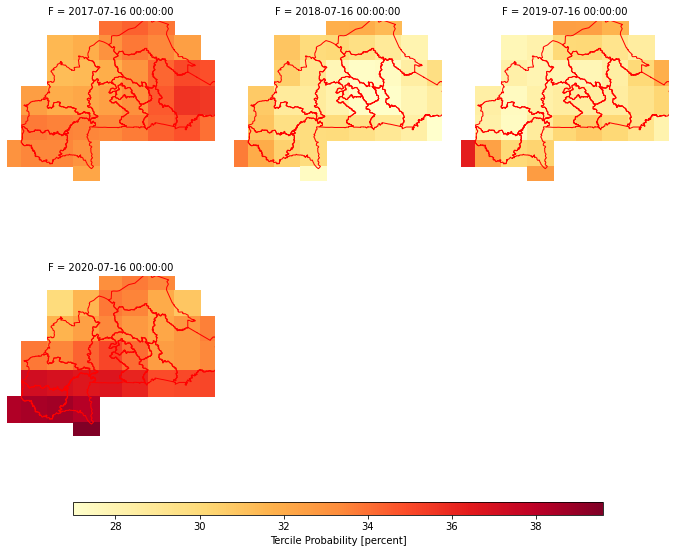

In [21]:
#check that interpolated values look fine
g=iri_clip_interp.where(iri_clip_interp.F.dt.month.isin([7]), drop=True).sel(L=1,C=0).prob.plot(
    col="F",
    col_wrap=3,
    cmap=mpl.cm.YlOrRd, 
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(10,10)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

we select the region of interest, shown below

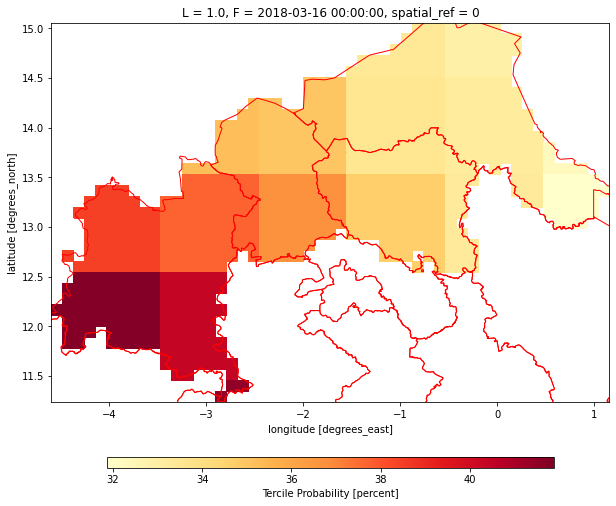

In [22]:
#testing if correct area
iri_interp_reg=iri_clip_interp.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.clip(gdf_reg.geometry.apply(mapping), iri_clip_interp.rio.crs, all_touched=False)
g=iri_interp_reg.sel(L=1,C=0,F="2018-03").prob.plot(
    cmap=mpl.cm.YlOrRd, 
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(10,10)
)
df_bound = gpd.read_file(adm1_bound_path)
df_bound.boundary.plot(linewidth=1, ax=g.axes, color="red")
ax.axis("off");

In [110]:
def compute_zonal_stats_xarray(raster,shapefile,lon_coord="lon",lat_coord="lat",var_name="prob"):
    raster_clip=raster.rio.set_spatial_dims(x_dim=lon_coord,y_dim=lat_coord).rio.clip(shapefile.geometry.apply(mapping),raster.rio.crs,all_touched=False)
    grid_mean = raster_clip.mean(dim=[lon_coord,lat_coord]).rename({var_name: "mean_cell"})
    grid_min = raster_clip.min(dim=[lon_coord,lat_coord]).rename({var_name: "min_cell"})
    grid_max = raster_clip.max(dim=[lon_coord,lat_coord]).rename({var_name: "max_cell"})
    grid_std = raster_clip.std(dim=[lon_coord,lat_coord]).rename({var_name: "std_cell"})
    grid_quant90 = raster_clip.quantile(0.9,dim=[lon_coord,lat_coord]).rename({var_name: "10quant_cell"})
    grid_percth40 = raster_clip.where(raster_clip.prob >=40).count(dim=[lon_coord,lat_coord])/raster_clip.count(dim=[lon_coord,lat_coord])*100
    grid_percth40=grid_percth40.rename({var_name: "40percth_cell"})
    raster_diff_bel_abv=raster_clip.sel(C=0)-raster_clip.sel(C=2)
    grid_dom = raster_clip.sel(C=0).where((raster_clip.sel(C=0).prob >=40) & (raster_diff_bel_abv>=5)).count(dim=[lon_coord,lat_coord])/raster_clip.count(dim=[lon_coord,lat_coord])*100
    grid_dom = grid_dom.rename({var_name: "40th_bavg_cell"})
    zonal_stats_xr = xr.merge([grid_mean, grid_min, grid_max, grid_std,grid_quant90,grid_percth40,grid_dom]).drop("spatial_ref")
    zonal_stats_df=zonal_stats_xr.to_dataframe()
    zonal_stats_df=zonal_stats_df.reset_index()
    return zonal_stats_df

In [111]:
stats_region=compute_zonal_stats_xarray(iri_clip_interp,gdf_reg)
stats_region["F"]=pd.to_datetime(stats_region["F"].apply(lambda x: x.strftime('%Y-%m-%d')))
stats_region["month"]=stats_region.F.dt.month

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [112]:
# stats_region.to_csv(stats_reg_path,index=False)

In [113]:
len(stats_region[stats_region["40th_bavg_cell"]>=10])/len(stats_region)*100

7.8431372549019605

In [116]:
stats_region_bavg=stats_region[(stats_region.C==0)]

And compute the statistics over this region, see a subset below

In [114]:
stats_region[(stats_region.C==0)&(stats_region.L==leadtime_mar)&(stats_region.F.dt.month==3)]

,C,F,L,mean_cell,min_cell,max_cell,std_cell,10quant_cell,quantile,40percth_cell,40th_bavg_cell,month
2,0,2017-03-16,3.0,36.902973,31.727321,41.107882,2.372418,40.120128,0.9,11.586207,11.586207,3
50,0,2018-03-16,3.0,31.016802,27.604931,35.812745,2.516681,34.336678,0.9,0.000000,0.000000,3
98,0,2019-03-16,3.0,36.896040,34.852292,38.713420,0.937665,38.090315,0.9,0.000000,0.000000,3
146,0,2020-03-16,3.0,29.905985,27.643195,34.985227,1.864129,31.348212,0.9,0.000000,0.000000,3
194,0,2021-03-16,3.0,25.743573,19.647599,38.699588,4.716883,30.255154,0.9,0.000000,0.000000,3


## Analyze statistics probability below average

Below the distribution of probability values is shown per month. \
This only includes the values for the below-average tercile, with a leadtime of {glue:text}`leadtime`. \
It should be noted that since we only have data from Mar 2017, these distributions contain maximum 5 values. \
From the distribution, it can be seen that a probability of 50% has never been reached since Mar 2017.

In [119]:
stats_mar=stats_region_bavg.loc[(stats_region_bavg.F.dt.month==3)&(stats_region_bavg.L==leadtime_mar)]
stats_jul=stats_region_bavg.loc[(stats_region_bavg.F.dt.month==7)&(stats_region_bavg.L==leadtime_jul)]

In [125]:
def comb_list_string(str_list):
    if len(str_list)>0:
        return " in "+", ".join(str_list)
    else:
        return ""

max_prob_mar=stats_mar.max_cell.max()
num_trig_mar=len(stats_mar.loc[stats_mar['max_cell']>=threshold_mar])
year_trig_mar=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['max_cell']>=threshold_mar].F.dt.year.unique()])

num_trig_jul=len(stats_jul.loc[stats_jul['max_cell']>=threshold_jul])
year_trig_jul=comb_list_string([str(y) for y in stats_jul.loc[stats_jul['max_cell']>=threshold_jul].F.dt.year.unique()])
max_prob_jul=stats_jul.max_cell.max()

In [126]:
glue("max_prob_mar", max_prob_mar)
glue("max_prob_jul", max_prob_jul)
glue("num_trig_mar", num_trig_mar)
glue("num_trig_jul", num_trig_jul)
glue("year_trig_mar", year_trig_mar)
glue("year_trig_jul", year_trig_jul)
glue("threshold_mar", threshold_mar)
glue("threshold_jul", threshold_jul)

41.10788156588872

36.66180243665207

1

0

' in 2017'

''

40

50

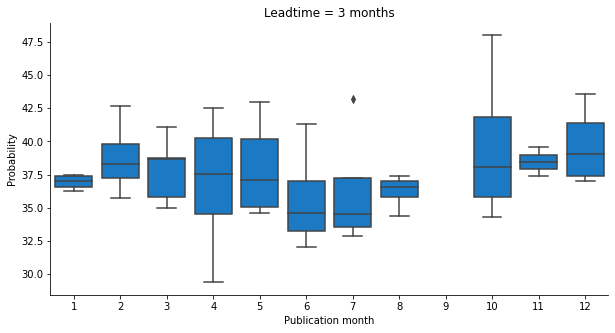

In [128]:
#plot distribution for forecasts with C=0 (=below average) for all months with leadtime = 3
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_region_bavg[stats_region_bavg.L==3],x="month",y="max_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Leadtime = 3 months")
ax.set_xlabel("Publication month");

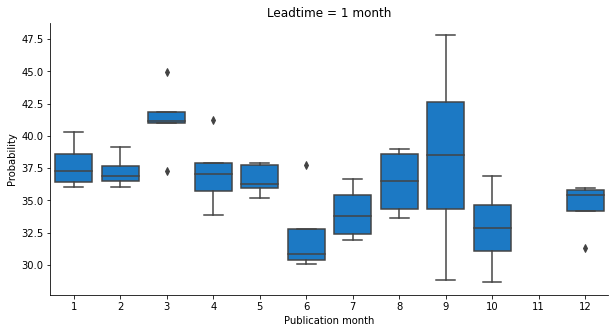

In [129]:
#plot distribution for forecasts with C=0 (=below average) for all months with leadtime = 3
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_region_bavg[stats_region_bavg.L==1],x="month",y="max_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Leadtime = 1 month")
ax.set_xlabel("Publication month");

More specifically we are interested in March and July, with a leadtime of 3 and 1 month respectively. 
The maximum values across all cells for the March forecasts has been {glue:text}`max_prob_mar:.2f`%, and for the July forecasts {glue:text}`max_prob_jul:.2f`% 
This would mean that if we would take the max cell as aggregation method, the threshold of {glue:text}`threshold_mar` for March would have been reached {glue:text}`num_trig_mar` times {glue:text}`year_trig_mar`. 
For July the threshold of {glue:text}`threshold_jul` would have been reached {glue:text}`num_trig_jul` times{glue:text}`year_trig_jul`."

In [131]:
stats_country=compute_zonal_stats_xarray(iri_clip_interp,gdf_adm1)
stats_country["F"]=pd.to_datetime(stats_country["F"].apply(lambda x: x.strftime('%Y-%m-%d')))
stats_country["month"]=stats_country.F.dt.month
glue("max_prob_mar_country",stats_country.loc[(stats_country.C==0)&(stats_country.L==leadtime_mar)&(stats_country.F.dt.month==3),'max_cell'].max())
glue("max_prob_jul_country",stats_country.loc[(stats_country.C==0)&(stats_country.L==leadtime_jul)&(stats_country.F.dt.month==7),'max_cell'].max())

42.183278335465324

38.67189416215341

To check if these below 50% and below 40% probabilities depend on the part of the country, we also compute the maximum values in the whole country across all years. 
<!-- While the values can be slightly higher in other regions, the 50% threshold is never reached.  -->

The maximum value for the March forecast in the whole country was {glue:text}`max_prob_mar_country:.2f`%. \
<!-- For July this was {glue:text}`max_prob_jul_country:.2f`%" -->

In [133]:
perc_for_40th=stats_country.loc[(stats_country.C==0)&(stats_country.L==leadtime_jul),'max_cell'].ge(40).value_counts(True)[True]*100
glue("perc_for_maxcell_40th",perc_for_40th)

25.49019607843137

Across all months, {glue:text}`perc_for_maxcell_40th:.2f`% of the forecasts with 1 month leadtime had a >=40% probability of below average rainfall in at least one cell across the **whole** country

Text(0.5, 0, 'Publication month')

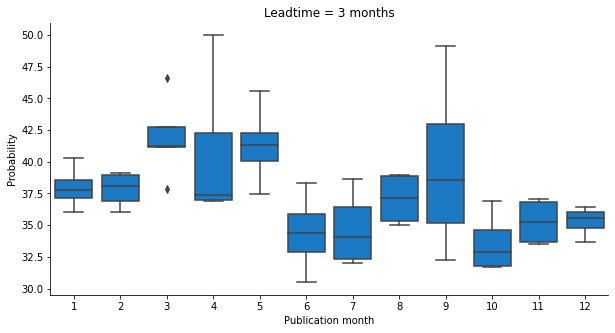

In [135]:
#plot distribution for forecasts with C=0 (=below average), for all months
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_country[(stats_country.C==0)&(stats_country.L==1)],x="month",y="max_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Leadtime = 3 months")
ax.set_xlabel("Publication month")

### Methods of aggregation
Note: all these computations only cover the region of interest

In [31]:
max_prob_mar=stats_region_bavg_lt.loc[stats_region_bavg_lt.F.dt.month==3,'max_cell'].max()
num_trig_mar_mean=len(stats_mar.loc[stats_mar['mean_cell']>=threshold_mar])
year_trig_mar_mean=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['mean_cell']>=threshold_mar].F.dt.year.unique()])
num_trig_mar_perc10=len(stats_mar.loc[stats_mar['10quant_cell']>=threshold_mar])
year_trig_mar_perc10=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['10quant_cell']>=threshold_mar].F.dt.year.unique()])
max_perc40_mar=stats_mar["40percth_cell"].max()
glue("num_trig_mar_mean", num_trig_mar_mean)
glue("year_trig_mar_mean", year_trig_mar_mean)
glue("num_trig_mar_perc10", num_trig_mar_perc10)
glue("year_trig_mar_perc10", year_trig_mar_perc10)
glue("max_perc40_mar", max_perc40_mar)

0

''

1

' in 2017'

11.586206896551724

While taking the max cell is the most extreme method of aggregation, we have many other possiblities. Such as looking at the mean, or at a percentage of cells. 
<!-- For the July forecast we wouldn't trigger with any method of aggregation, since we already didn't trigger with the max methodology.  -->

For March, when using the mean method aggregation, the trigger would have been met {glue:text}`num_trig_mar_mean` times{glue:text}`year_trig_mar_mean`.

Below the distribution of the percentage of the area with >=40% probability is shown for March. From here it can be seen that the maximum percentage is {glue:text}`max_perc40_mar:.2f`%.
We look at the distribution of the percentage of the area with >=40% probability of below avg rainfall for the admins of interest, across all forecasts with a leadtime of {glue:text}`leadtime`. 
When requiring 10% of cells to be above 40% this would be met {glue:text}`num_trig_mar_perc10` times{glue:text}`year_trig_mar_perc10`.

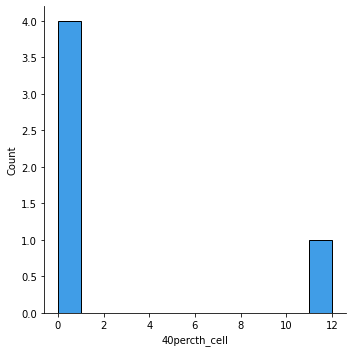

In [136]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for March
g=sns.displot(stats_mar["40percth_cell"],color="#007CE0",binwidth=1)

The plot below shows the occurences across all months and all leadtimes where at least 1% of the cells had a probability of at least 40% for below average rainfall. We can see that the occurrence of this is pretty rare.

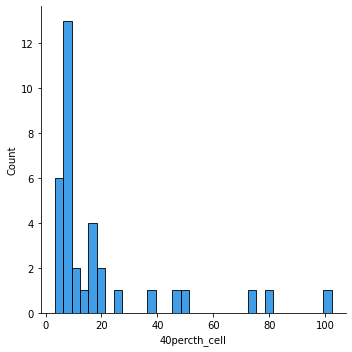

In [138]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
g=sns.displot(stats_region_bavg.loc[stats_region_bavg["40percth_cell"]>=1,"40percth_cell"],color="#007CE0",binwidth=3)

<!-- While we can include the spatial severity in the trigger threshold, we should also take into account that the spatial uncertainty of seasonal forecasts is large. 

Given the size of the area of interest, it might therefore be better to only focus on whether any cell within that region reached the probability threshold. However, in this case 40% might be too sensitive of a trigger -->

### Examine dominant tercile pixel
TODO: elaborate this section
Besides setting a threshold on the below average tercile, we also want to be sure that the below average tercile is the dominant tercile. We therefore require, at the pixel level that 
probability below average >= (probability above average + 5%)

Moreover on the above analysis, we require at least 10% of the area meeting the threshold. This results in the following activations for our periods of interest

In [140]:
stats_mar[stats_mar["40th_bavg_cell"]>=10]

,C,F,L,mean_cell,min_cell,max_cell,std_cell,10quant_cell,quantile,40percth_cell,40th_bavg_cell,month
2,0,2017-03-16,3.0,36.902973,31.727321,41.107882,2.372418,40.120128,0.9,11.586207,11.586207,3


In [141]:
stats_jul[stats_jul["40th_bavg_cell"]>=10]

,C,F,L,mean_cell,min_cell,max_cell,std_cell,10quant_cell,quantile,40percth_cell,40th_bavg_cell,month


## OLD: Examine dominant tercile region

**NOTE: this is outdated since this compares the 10% of the area numbers, while we now compare the terciles at pixel level

Besides knowing if the below average tercile reaches a certain threshold, it is also important to understand if the below average tercile is the dominant tercile. Where dominant indicates the tercile with the highes probability. Else, it wouldn't be logical to anticipate based on the likelihood of below average rainfall. 

Since we are working with aggregation we have to determine what method we use to set the probability of below average, normal, and above average precipitation. 
For this analysis we look at the cell with the maximum probability for each tercile
<!-- For this analysis we look at the 10% percentile boundary, meaning that 10% of the area has a probability of at least x% for the given tercile. -->

<!-- This threshold was set since we want a substantial part of the region to meet the threshold. It wasn't set at a higher percentage, because from the above analysis we saw that this barely occurred in the past 4 years. However, this threshold and method of aggregation is still open for discussion. 
 -->
Note: all these computations only cover the region of interest

In [73]:
leadtime=1

In [74]:
from dateutil.relativedelta import relativedelta

In [75]:
def get_forecastmonth(pub_month,leadtime):
    return pub_month+relativedelta(months=+int(leadtime))
stats_region["for_start"]=stats_region.apply(lambda x: get_forecastmonth(x.F,leadtime), axis=1)
stats_region["for_start_month"]=stats_region.for_start.dt.to_period("M")
stats_region["for_end_month"]=stats_region.apply(lambda x: get_forecastmonth(x.for_start,2), axis=1).dt.to_period("M")

In [76]:
aggr_meth="10quant_cell"

In [77]:
stats_region["publication_month"]=stats_region["F"].dt.to_period("M")
stats_region_aggrmeth=stats_region.pivot(index=['publication_month',"for_start_month","for_end_month",'L'], columns='C', values=aggr_meth).reset_index().rename(columns={0:"bel_avg",1:"normal",2:"abv_avg"})
#remove index name
stats_region_aggrmeth = stats_region_aggrmeth.rename_axis(None, axis=1)  

In [78]:
stats_region_aggrmeth_lt=stats_region_aggrmeth[stats_region_aggrmeth.L==leadtime]

<!-- Below all publication months are shown, where the numbers indicate the 10% boundary for each tercile. Those that have a probability of at least 40 are marked in red. We can see that for only 3 months this occurred for the below average tercile. For the above average tercile this is a more common phenomenon. 

We can see that for all occurrences that there was an at least 40% probability, this only occurred in one tercile, i.e. this is also the dominant tercile.  However, the differences can be quite small, for example in March 2018 and March 2021. 

Especially around March 2021 we can see an interesting pattern, where in February and April the forecast indicates a higher probability of above average instead of below average precipitation. Note however that these are forecasting different periods. I.e. the forecast of March is projecting for AMJ while the one in April is projecting for MJJ.

When focussing on our months of interest, namely March and July, we can see that for March in 4 out of 5 years the below average was the dominant tercile. The opposite for July is true, where all years so far showed the above average as dominant tercile. -->

Below all publication months are shown, where the numbers indicate the cell with the maximum probability touching the region of interest for each tercile. Those that have a probability of at least 40% are marked in red. We can see that this occurs more often for above than below average. Moreover, it does occurr that both the below and above average tercile meet the threshold.

Questions

- should there be a minimum gap in probabilities between the terciles? 
- should we somehow check that the forecast is consistent across leadtimes?
     - currently only displaying values for leadtime=1 month!

Note: the NaNs in the table indicate a dry mask during those months

In [80]:
stats_region_aggrmeth_lt.drop("L",axis=1).set_index(["publication_month","for_start_month","for_end_month"]).to_csv(os.path.join(iri_exploration_dir,f"bfa_tercile_prob_l{leadtime}_{aggr_meth}.csv"))

In [79]:
stats_region_aggrmeth_lt.drop("L",axis=1).set_index(["publication_month","for_start_month","for_end_month"]).style.apply(lambda x: ["color: red" if v >=40 else "" for v in x], axis = 1).set_precision(2)

,,,bel_avg,normal,abv_avg
publication_month,for_start_month,for_end_month,,,
2017-03,2017-04,2017-06,35.57,31.03,42.56
2017-04,2017-05,2017-07,37.65,30.61,44.02
2017-05,2017-06,2017-08,36.30,31.14,39.93
2017-06,2017-07,2017-09,27.68,30.06,48.69
2017-07,2017-08,2017-10,34.24,31.76,37.15
2017-08,2017-09,2017-11,34.44,31.60,36.13
2017-09,2017-10,2017-12,38.23,32.40,35.16
2017-10,2017-11,2018-01,36.90,31.39,31.80
2017-11,2017-12,2018-02,nan,nan,nan


The probabilities for March
<!-- and July  -->
are shown below, where the dominant tercile is highlighted

In [39]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['color: red' if v else 'black' for v in is_max]

stats_region_aggrmeth_lt[stats_region_aggrmeth_lt.publication_month.dt.month.isin([3])].drop("L",axis=1).set_index(["publication_month"]).style.apply(highlight_max,axis=1).set_precision(2)

,bel_avg,normal,abv_avg
publication_month,,,
2017-03,40.12,30.94,36.05
2018-03,34.34,30.86,41.80
2019-03,38.09,30.04,34.51
2020-03,31.35,30.71,43.32
2021-03,30.26,28.26,55.67


In [38]:
# stats_region_aggrmeth_lt[stats_region_aggrmeth_lt.publication_month.dt.month.isin([7])].drop("L",axis=1).set_index(["publication_month"]).style.apply(highlight_max,axis=1).set_precision(2)

## Test different method of computing stats

In [41]:
def compute_zonal_stats(ds, raster_transform, adm_path,adm_col,percentile_list=np.arange(10,91,10)):
    # compute statistics on level in adm_path for all dates in ds
    df_list = []
    for date in ds.F.values:
        df = gpd.read_file(adm_path)[[adm_col,"geometry"]]
        ds_date = ds.sel(F=date)
        
        df[["mean_cell", "max_cell", "min_cell"]] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date.values, affine=raster_transform, nodata=np.nan))[
            ["mean", "max", "min"]]

        df[[f"percentile_{str(p)}" for p in percentile_list]] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date.values, affine=raster_transform, nodata=np.nan,
                        stats=" ".join([f"percentile_{str(p)}" for p in percentile_list])))[
            [f"percentile_{str(p)}" for p in percentile_list]]

        df["date"] = pd.to_datetime(date.strftime("%Y-%m-%d"))

        df_list.append(df)
    df_hist = pd.concat(df_list)
    #drop the geometry column, else csv becomes huge
    df_hist=df_hist.drop("geometry",axis=1)

    return df_hist

In [42]:
#this was the old method
iri_date=iri_clip_interp.sel(L=1,C=0,F="2018-03").prob
#add recalc=True such that transform is recalculated after the interpolation, instead of using the cached version!!
#if using transform_interp, i.e. the output of interpolate_ds, the results are slightly different. Probability due to a bit less precision in the transform
df_stats=compute_zonal_stats(iri_date,iri_clip_interp.rio.transform(recalc=True),adm1_bound_path,parameters["shp_adm1c"])
df_stats["date"]=pd.to_datetime(df_stats["date"])
df_stats[(df_stats.ADM1_FR.isin(adm_sel))&(df_stats.date.dt.month==3)]

,ADM1_FR,mean_cell,max_cell,min_cell,percentile_10,percentile_20,percentile_30,percentile_40,percentile_50,percentile_60,percentile_70,percentile_80,percentile_90,date
0,Boucle du Mouhoun,39.565648,41.878787,35.271130,37.735180,37.735180,38.453984,38.453984,40.363758,40.363758,40.363758,41.792957,41.792957,2018-03-16
4,Centre-Nord,34.396130,36.708924,33.223838,33.296230,33.585452,33.585452,34.723427,34.723427,34.723427,34.723427,34.723427,34.991765,2018-03-16
9,Nord,36.038983,37.735180,34.991765,34.991765,34.991765,35.271130,35.271130,36.708924,36.708924,36.708924,36.708924,37.529929,2018-03-16
11,Sahel,33.304035,34.991765,31.873917,32.275978,32.897940,33.223838,33.223838,33.223838,33.434319,33.585452,33.585452,33.585452,2018-03-16


In [43]:
#geocube is the suggested method by rioxarray
#results are slightly different than current method, and don't understand why
#with geocube you can directly compute different regions, but think you have to compute separability per other variable (L,F,C)
import geopandas
import numpy
import rioxarray
import xarray as xr
from geocube.api.core import make_geocube
gdf_adm1=gpd.read_file(adm1_bound_path)
#make categorical value
gdf_adm1["mukey"] = range(len(gdf_adm1))
gdf_adm1["mukey"]=gdf_adm1["mukey"].astype(int)

mask = make_geocube(
    gdf_adm1,
    measurements=["mukey"],
    like=iri_ds,
    fill=0,
)

out_grid = make_geocube(
    vector_data=gdf_adm1,
    measurements=["mukey"],
    like=iri_clip_interp.sel(L=1,C=0,F="2018-03").prob, # ensure the data are on the same grid
    fill=np.nan
)
out_grid["iri"] = iri_clip_interp.rename({'lon': 'x','lat': 'y'}).sel(L=1,C=0,F="2018-03").prob

grouped_elevation = out_grid.drop("spatial_ref").groupby(out_grid.mukey)
grid_mean = grouped_elevation.mean().rename({"iri": "iri_mean"})
grid_min = grouped_elevation.min().rename({"iri": "iri_min"})
grid_max = grouped_elevation.max().rename({"iri": "iri_max"})
grid_std = grouped_elevation.std().rename({"iri": "iri_std"})
zonal_stats_xr = xr.merge([grid_mean, grid_min, grid_max, grid_std])
stats_region=zonal_stats_xr.to_dataframe()
stats_region.reset_index().merge(gdf_adm1,on="mukey")[["ADM1_FR","iri_mean"]]

,ADM1_FR,iri_mean
0,Boucle du Mouhoun,39.582661
1,Cascades,41.347100
2,Centre,37.033878
3,Centre-Est,34.245415
4,Centre-Nord,34.458694
5,Centre-Ouest,39.382242
6,Centre-Sud,37.001245
7,Est,31.884276
8,Hauts-Bassins,42.180311
9,Nord,36.005561


### Archive

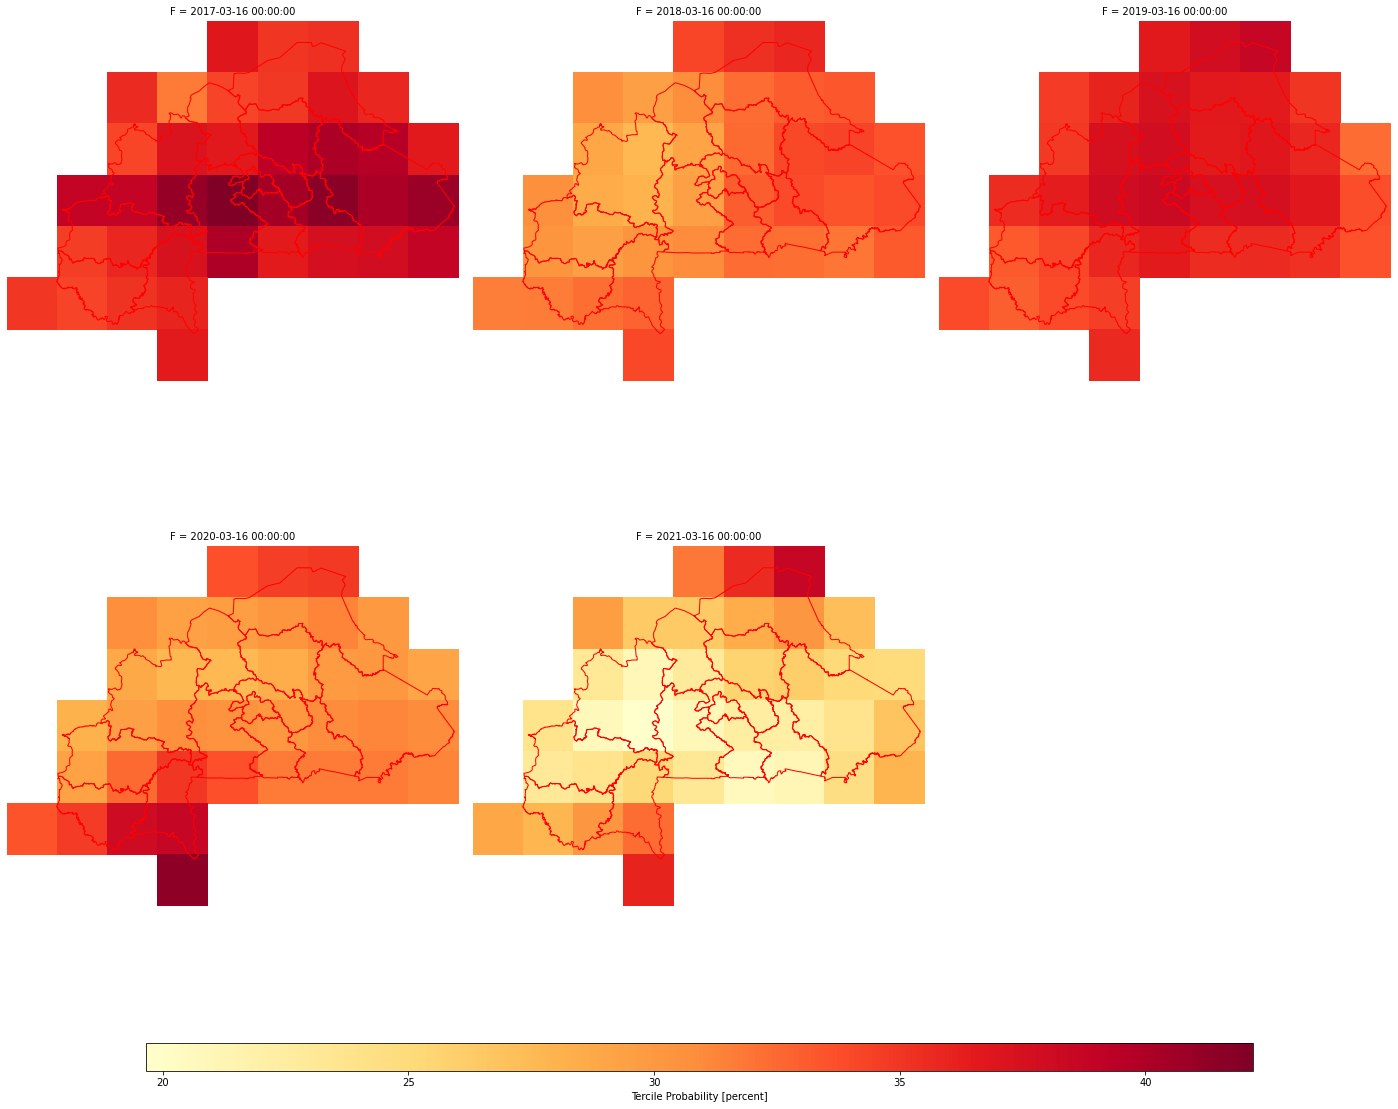

In [11]:
g=iri_clip.where(iri_clip.F.dt.month.isin([3]), drop=True).sel(L=3,C=0).prob.plot(
    col="F",
    col_wrap=3,
    cmap=mpl.cm.YlOrRd,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(20,20)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")
# fig.tight_layout()